# Benchmark C File

In [18]:
%%file benchmark.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <unistd.h>
#include <stdint.h>
#include <sys/time.h>

//size_t is an unsigned integer data type, represent the size of objects in bytes, commonly used as the return type by the sizeof operator.
//If the compiler is 32-bit, size_t is a typedef (alias) for unsigned int.
//If the compiler is 64-bit, it becomes a typedef for unsigned long long
char* pretty_size(size_t rawsize);// rawsize is in bytes.

char* pretty_time(double duration,int input_unit);

// the second parameter tells pretty_time() what unit your duration is expressed in.
#define U_NANOSECONDS  0
#define U_MICROSECONDS 1
#define U_MLLISECONDS  2
#define U_SECONDS      3

// metric units
#define THOUSAND_BYTES 1000
static char *size_units[]={ "B", "kB", "MB", "GB" };

// IEC units
// #define THOUSAND_BYTES 1024
// static char *size_units[]={ "B", "kB", "MB", "GB" };

/* typedef char data_t; */
/* typedef short data_t; */
/* typedef int data_t; */
typedef double data_t;

size_t size;  // size of data array. in Bytes
data_t *data; // data array itself. malloc'ed
//size_t count; // nb elements in the data array
//int stride;   // step size (in units of data_t)

char* pretty_size(size_t rawsize)
{
    int unit=0;
    float size=rawsize;

    while(size >= THOUSAND_BYTES)
    {
        size/=THOUSAND_BYTES;
        unit++;
    }

    char* ret=(char*)malloc(10);// room for:  NNNN.N digits, 2-char unit, and trailing null

    if( size == (float)(int)size )
        sprintf(ret,"%d%s",(int)size,size_units[unit]);
    else
        sprintf(ret,"%.1f%s",size,size_units[unit]);

    return ret;
}


static char* time_units[]={ "ns", "us", "ms", "s"};

char * pretty_time(double duration,int input_unit)
{
    int unit = input_unit;
    while(duration >1000)
    {
        duration/=1000;
        unit++;
    }

    char *ret=(char*)malloc(10); // room for NNNN.NN digits, 2-char unit, and trailing null

    if( duration == (float)(int)duration)
        sprintf(ret,"%d%s",(int)duration,time_units[unit]);
    else
        sprintf(ret,"%.2f%s",duration,time_units[unit]);

    return ret;
}

data_t test(size_t count, int stride)
{
    data_t result=0;
    size_t i;
    for( i=0; i<count; i += stride )
    {
        result += data[i];
    }
    return result;
}

void fill(size_t count, int stride)
{
    srand(time(NULL));

    size_t i;
    for( i=0; i<count; i += stride )
    {
        data[i] += i*3.14*rand();
    }
}


int main(int argc, char* argv[])
{
    size_t count; // nb elements in the data array
    int stride;   // step size (in units of data_t)
    int functionoption;
    if(argc != 3)
    {
        printf("usage: %s SIZE STRIDE\n",argv[0]);
        printf("\n");
        printf("Allocate a memory buffer and walk it, reporting read throughput.\n");
        printf("  SIZE is the size of the buffer (in bytes).\n");
        printf("  STRIDE is the distance between two successive reads (in 64bit items).\n");
        exit(1);
    }

    //Parses the C-string str interpreting its content as an integral number, which is returned as a value of type long long int
    size=atoll(argv[1]);
    //converts a string of characters representing a numeral into a number of int
    stride=atoi(argv[2]);


    count=size/sizeof(data_t);
    printf("size=%ju (%s ; %ju items of size %ju) stride=%d\n",
           (uintmax_t)size, pretty_size(size),
           (uintmax_t)count, (uintmax_t)sizeof(data_t), stride);

    data=(data_t*) malloc(size);

    double duration=0; // in microseconds
    int repeats=1;
    while(1)
    {
        volatile data_t dummy=0;

        dummy+=test(count, stride);//cache warm-up

        clock_t begin=clock();
        int r;

        for(r=0;r<repeats;r++)
        {
            dummy+=test(count, stride);
        }

        clock_t end=clock();

        duration=(uintmax_t)end - (uintmax_t)begin ;

        printf("%d repeats -> %s\n",repeats,pretty_time(duration,U_MICROSECONDS));

        if(duration > 1000)
            break;

        repeats = repeats*10;
    }

    duration = duration/repeats;

    printf("=> one repeat -> %s\n",pretty_time(duration,U_MICROSECONDS));

    size_t quantity = (count/stride)*sizeof(data_t);// in bytes again

    printf("read %s in %s = %.1f MB/s\n",
           pretty_size(quantity),
           pretty_time(duration,U_MICROSECONDS),
           ((float)quantity)/duration // bytes per microseconds = megabytes per second
           );
    return 0;
}

Overwriting benchmark.c


In [19]:
!gcc -o benchmark benchmark.c

In [20]:
!./benchmark 3000 3

size=3000 (3kB ; 375 items of size 8) stride=3
1 repeats -> 2us
10 repeats -> 5us
100 repeats -> 48us
1000 repeats -> 486us
10000 repeats -> 5.00ms
=> one repeat -> 0.50us
read 1kB in 0.50us = 1998.0 MB/s


In [25]:
import numpy as np

import subprocess

# repeat execution for this number of times, and only keep the median
# value. (simplistic way to reduce noise)
count = 20


for mag in range(10,34): # from 2^10 (1kB) to 2^27 (64MB)
    size = 2**mag
    for stride in range(1,50,2): #1,30,2

        results=[]
        for repeat in range(count):
            log=subprocess.check_output(["./benchmark",
                                         str(size),
                                         str(stride)]);

            for l in log.splitlines():
                l=str(l)
                if "MB/s" in l:
                    results.append( float(l[ l.find('=')+1: l.find('MB/s') ]) )

        #print(f'{size} {stride} {np.median(results)}')
        median_result = np.median(results)
        # Append data to a text file
        with open("output.txt", "a") as file:
          file.write(f"{size} {stride} {median_result}\n")

        print(f"Data saved to output.txt: {size} {stride} {median_result}")

Data saved to output.txt: 1024 1 2336.55
Data saved to output.txt: 1024 3 2419.9
Data saved to output.txt: 1024 5 2446.0
Data saved to output.txt: 1024 7 2506.1000000000004
Data saved to output.txt: 1024 9 2463.45
Data saved to output.txt: 1024 11 2407.95
Data saved to output.txt: 1024 13 2351.8
Data saved to output.txt: 1024 15 2288.55
Data saved to output.txt: 1024 17 2254.45
Data saved to output.txt: 1024 19 2214.6000000000004
Data saved to output.txt: 1024 21 2237.25
Data saved to output.txt: 1024 23 2151.7
Data saved to output.txt: 1024 25 2140.2
Data saved to output.txt: 1024 27 1993.8
Data saved to output.txt: 1024 29 1988.1999999999998
Data saved to output.txt: 1024 31 1933.5
Data saved to output.txt: 1024 33 1753.75
Data saved to output.txt: 1024 35 1761.5
Data saved to output.txt: 1024 37 1751.85
Data saved to output.txt: 1024 39 1783.7
Data saved to output.txt: 1024 41 1782.4
Data saved to output.txt: 1024 43 1489.75
Data saved to output.txt: 1024 45 1442.05
Data saved to ou

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import math
import sys

def pretty_speed(speed,pos):
    """convert speed to human-readable form.
'speed' is given in bytes.
'pos' is a dummy parameter, required by matplotlib's FuncFormatter.
    """
    suffixes=['MB/s','GB/s']
    unit=0
    speed=int(speed)# initially in MB/s
    while speed>1000:
        speed/=1000. # 1000 or 1024 ? cf pretty.c
        unit+=1
    # only keep the decimal part when there is one !
    string=str(speed)
    if string[-2:] == ".0":
        string=string[:-2]
    return string+suffixes[unit]

def pretty_size(logsize,pos):
    """convert size to human-readable form.
'logsize' is the log of the size we want to represent.
'pos' is a dummy parameter, required by matplotlib's FuncFormatter.
"""

    suffixes=['B','kB','MB','GB']
    unit=0
    size=int(2**logsize)# now in bytes
    while size>1000:
        size//=1000
        unit+=1
    return str(size)+suffixes[unit]


In [27]:
with open('output.txt') as f:
  data = f.read()
  data = data.splitlines()

  # stride
  x = [int(row.split(' ')[1]) for row in data]

  # working set size
  y = [int(row.split(' ')[0])  for row in data]
  y = np.log2(y) # we cheat to get a logarithmic Y axis

  # throughput
  z = [float(row.split(' ')[2]) for row in data]

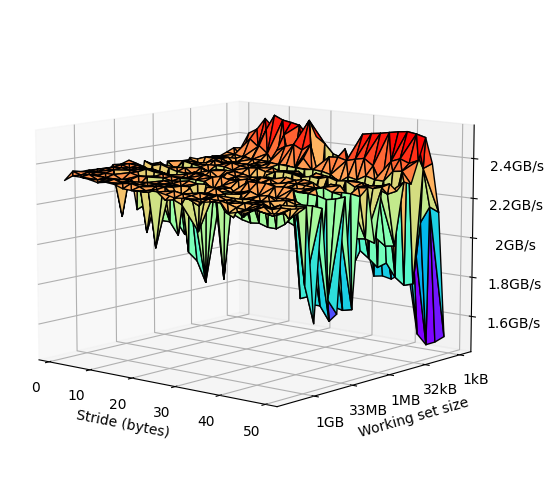

In [28]:
# plot setup
fig=plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # reduce whitespace margins around plot (I hope?)
ax =fig.add_subplot(projection='3d')
ax.invert_yaxis()
ax.view_init(elev=10,azim=310)

ax.plot_trisurf(x,y,z,cmap='rainbow',edgecolors='black')

ax.set_xlabel('Stride (bytes)')
#ax.set_xlim(right=0)

ax.set_ylabel('Working set size')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(pretty_size))

ax.set_zlabel('Throughput',labelpad=20)
ax.tick_params(axis='z', pad=10) #
ax.zaxis.set_major_formatter(mpl.ticker.FuncFormatter(pretty_speed))
plt.show()

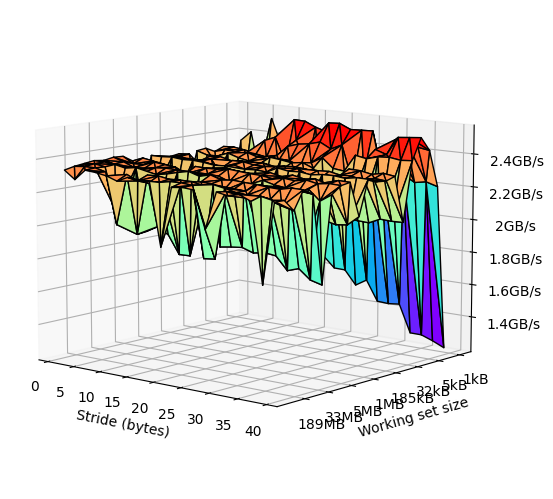

In [24]:
# plot setup
fig=plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1) # reduce whitespace margins around plot (I hope?)
ax =fig.add_subplot(projection='3d')
ax.invert_yaxis()
ax.view_init(elev=10,azim=310)

ax.plot_trisurf(x,y,z,cmap='rainbow',edgecolors='black')

ax.set_xlabel('Stride (bytes)')
#ax.set_xlim(right=0)

ax.set_ylabel('Working set size')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(pretty_size))

ax.set_zlabel('Throughput',labelpad=20)
ax.tick_params(axis='z', pad=10) #
ax.zaxis.set_major_formatter(mpl.ticker.FuncFormatter(pretty_speed))
plt.show()